[<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/snntorch_alpha_w.png?raw=true' width="400">](https://github.com/jeshraghian/snntorch/)

# snnTorch - Knowledge Distillation
## A project about predicting sine waves with compressed models.
### By Sean M. Venadas
### With help from: Skye Gunasekaran, Jason Eshraghian

This student-made tutorial was made for the class ECE183 (F2023) as part of UC Santa Cruz. It is only a small portion of a bigger project: predicting seizures through the use of SNNs on EEG signals. This subset project was designed to practice implementing methods of knowledge distillation. If you have any questions, please consider emailing me: svenadas@ucsc.edu.

# Project Overview

### What is Knowledge Distilaltion?

In machine learning, as models become larger and more complex, there presents a need to simplify them for sake of efficiency. Knowledge distillation (KD) is a technique that helps with this. In summary, a large, complex model is trained and its knowledge is then transferred to a smaller, architecturally-similar model that is tasked to do a similar job. The purpose of this is to improve performance on a smaller model which optimizes factors such as computation speeds and energy consumption. In KD, the larger model is referred to as the "teacher model" and the smaller model is referred to as the "student model". This makes sense when thinking about a teacher-student relationship in real life, where the teacher condenses information for the student.

In more technical detail, KD majorly depends on these different factors:
*   model architecture
*   distillation processes
*   training methods



For model architecture, the teacher is supposed to be much larger and more complex than the student (Figure 1). KD is mostly applied to neural network models so the teacher-student models can differ in terms of factors such as model width, model depth, parameter count, etc.

For distillation processes, it's important to consider how knowledge is distilled and transferred for the student model utilize it. There are different methods available and what is chosen depends on the task at hand.

For training methods, there are different techniques. For example "offline distillation" is where the teacher model is fully trained before training the student model. In "online distillation" the teacher model keeps being updated as the student is training.




### What to Expect:


For this tutorial, the main goal is to demonstrate knowledge distillation.

We will be forecasting a sine wave using the knowledge distillation process. How this tutorial is set up is that there is one teacher model and two student models. First, a model called the "base student model" will exhibit use of MSE and optimization to predict a sine wave; this model is not actually a student and only given its name because it is the same size as the student. Next are the teacher-student models. There is a teacher model with much bigger model width that trains itself. It's parameters are updated and logits are softmaxxed to apply a KL divergence method to train the actual student model.

To get started the we generate two different sine waves. The teacher is given a more complex sine wave to provide more knowledge for the student model.

The teacher model and student model are defined with a spiking neural network which includes linear and LIF layers.

The models then "predict" the sine waves by running them through loops. In these loops a wave is generated and then compared to the data from the actual wave to compute a loss function. The optimizer comes in to try to minimize the value of the loss function.

# 1. Getting Started

### 1.1 Downloads

Install the required libraries by clicking into the following cell and pressing `Shift+Enter`.

In [4]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 5.6 MB/s eta 0:00:00


In [5]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

### 1.2 Generate the Dataset

In order to get started, we need to set up two sinusoid signals to represent the teacher and student. Assuming basic knowledge on Knowledge Distillation (KD), you should know that you want your teacher model to be bigger in architecture. This is because we want to give the student as much information as possible.

In [6]:
def generate_sinusoid_data(num_points, amplitude, frequency, phase, noise_std=0.1):
    t = np.linspace(0, 1, num_points, dtype=np.float32)
    sinusoid = amplitude * np.sin(2 * np.pi * frequency * t + phase)
    noisy_sinusoid = sinusoid + np.random.normal(0, noise_std, size=num_points)
    return t, noisy_sinusoid

# The parameters below can be edited to your liking
num_points = 100
amplitude_teacher, frequency_teacher, phase_teacher = 1.0, 2.5, 0.0
amplitude_student, frequency_student, phase_student = 1.0, 2.0, 0.5 #phase-shifted to test pattern detection

In [7]:
# Generates signals with specified parameters in previous cell
t_teacher, teacher_data = generate_sinusoid_data(num_points, amplitude_teacher, frequency_teacher, phase_teacher)
t_student, student_data = generate_sinusoid_data(num_points, amplitude_student, frequency_student, phase_student)

In [8]:
# Convert data to PyTorch tensors with dtype float32
t_teacher_tensor = torch.from_numpy(t_teacher).view(-1, 1).float()
teacher_data_tensor = torch.from_numpy(teacher_data).view(-1, 1).float()

t_student_tensor = torch.from_numpy(t_student).view(-1, 1).float()
student_data_tensor = torch.from_numpy(student_data).view(-1, 1).float()

# 2. Define the Models

In [9]:
lr = 0.001
epochs = 300
hidden_teacher = 256
hidden_student = 8

In [10]:
class SinusoidModel(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps=100, hidden=256):
        super().__init__()

        self.timesteps = timesteps # number of time steps to simulate the network
        self.hidden = hidden # number of hidden neurons
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # randomly initialize decay rate and threshold for layer 1
        beta_in = torch.rand(self.hidden)
        thr_in = torch.rand(self.hidden)

        # layer 1
        self.fc_in = torch.nn.Linear(in_features=1, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta_in, threshold=thr_in, learn_beta=True, spike_grad=spike_grad)

        # randomly initialize decay rate and threshold for layer 2
        beta_hidden = torch.rand(self.hidden)
        thr_hidden = torch.rand(self.hidden)

        # layer 2
        self.fc_hidden = torch.nn.Linear(in_features=self.hidden, out_features=self.hidden)
        self.lif_hidden = snn.Leaky(beta=beta_hidden, threshold=thr_hidden, learn_beta=True, spike_grad=spike_grad)

        # randomly initialize decay rate for output neuron
        beta_out = torch.rand(1)

        # layer 3: leaky integrator neuron. Note the reset mechanism is disabled and we will disregard output spikes.
        self.fc_out = torch.nn.Linear(in_features=self.hidden, out_features=1)
        self.li_out = snn.Leaky(beta=beta_out, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none")

    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem_1 = self.lif_in.init_leaky()
        mem_2 = self.lif_hidden.init_leaky()
        mem_3 = self.li_out.init_leaky()

        # Empty lists to record outputs
        mem_3_rec = []

        # Loop over
        for step in range(self.timesteps):
            x_timestep = x[step, :]

            cur_in = self.fc_in(x_timestep)
            spk_in, mem_1 = self.lif_in(cur_in, mem_1)

            cur_hidden = self.fc_hidden(spk_in)
            spk_hidden, mem_2 = self.lif_hidden(cur_hidden, mem_2)

            cur_out = self.fc_out(spk_hidden)
            _, mem_3 = self.li_out(cur_out, mem_3)

            mem_3_rec.append(mem_3)

        return torch.stack(mem_3_rec)

# 3. Train the Models

### No Knowledge Distillation (Base Student Model only)

In [11]:
# Create temporary student model
base_student_model = SinusoidModel(hidden=hidden_student)

# Loss function with MSE
def base_custom_loss(y_true, y_pred):
    mse_loss = nn.functional.mse_loss(y_true, y_pred)
    return mse_loss

# Create optimizer for temporary student model
base_student_optimizer = optim.Adam(base_student_model.parameters(), lr=lr)

# Train the temporary student model on student data
for epoch in range(epochs):
    base_student_optimizer.zero_grad()
    base_student_output = base_student_model(t_student_tensor)
    loss_base_student = base_custom_loss(student_data_tensor, base_student_output)
    loss_base_student.backward()
    base_student_optimizer.step()

### Knowledge Distillation (Teacher & KD Student Models)

In [12]:
# Create teacher model
teacher_model = SinusoidModel(hidden=hidden_teacher)

# Loss function without KL divergence term
criterion_teacher = nn.MSELoss()

# Create optimizer for teacher model
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=lr)

# Train the teacher model on teacher data
for epoch in range(epochs):
    teacher_optimizer.zero_grad()
    teacher_output = teacher_model(t_teacher_tensor)
    loss_teacher = criterion_teacher(teacher_output, teacher_data_tensor)
    loss_teacher.backward()
    teacher_optimizer.step()

In [13]:
# Create final student model
kd_student_model = SinusoidModel(hidden=hidden_student)

# Loss function with KL divergence term
def kd_custom_loss(y_true, y_pred, teacher_logits):
    mse_loss = nn.functional.mse_loss(y_true, y_pred)
    kl_loss = nn.functional.kl_div(F.log_softmax(y_pred, dim=1), F.softmax(teacher_logits, dim=1), reduction='batchmean')
    return mse_loss + kl_loss

# Create optimizer for student model
kd_student_optimizer = optim.Adam(kd_student_model.parameters(), lr=lr)

# Train the student model on student data with KL divergence term
for epoch in range(epochs):
    teacher_model.eval()
    kd_student_optimizer.zero_grad()
    kd_student_output = kd_student_model(t_student_tensor)
    with torch.no_grad():
      teacher_logits = teacher_model(t_student_tensor)
    loss_kd_student = kd_custom_loss(student_data_tensor, kd_student_output, teacher_logits)
    loss_kd_student.backward(retain_graph=True)  # Set retain_graph=True to allow multiple backward passes
    kd_student_optimizer.step()

# 4. Results

In [14]:
def evaluate_model(model, input_data, target_data):
    model.eval()
    with torch.no_grad():
        predictions = model(input_data)
        mse = nn.functional.mse_loss(predictions, target_data)
    return mse.item()

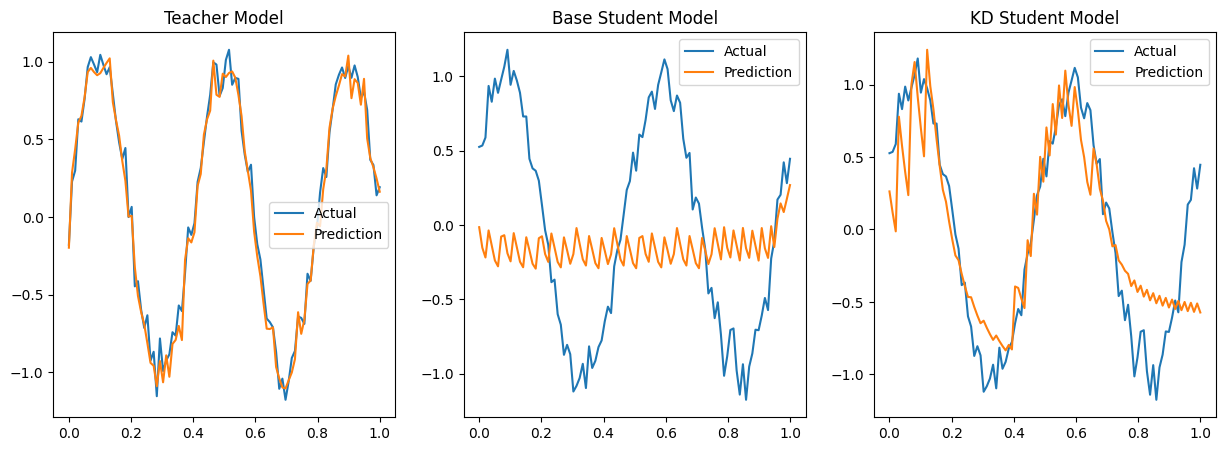

In [15]:
# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(t_teacher, teacher_data, label='Actual')
plt.plot(t_teacher, teacher_model(t_teacher_tensor).detach().numpy(), label='Prediction')
plt.legend()
plt.title('Teacher Model')

plt.subplot(1, 3, 2)
plt.plot(t_student, student_data, label='Actual')
plt.plot(t_student, base_student_model(t_student_tensor).detach().numpy(), label='Prediction')
plt.legend()
plt.title('Base Student Model')

plt.subplot(1, 3, 3)
plt.plot(t_student, student_data, label='Actual')
plt.plot(t_student, kd_student_model(t_student_tensor).detach().numpy(), label='Prediction')
plt.legend()
plt.title('KD Student Model')

plt.show()

In [16]:
mse_teacher = evaluate_model(teacher_model, t_teacher_tensor, teacher_data_tensor)
mse_base_student = evaluate_model(base_student_model, t_student_tensor, student_data_tensor)
mse_kd_student = evaluate_model(kd_student_model, t_student_tensor, student_data_tensor)

print(f"MSE for Teacher Model:       {mse_teacher}")
print(f"MSE for Base Student Model:  {mse_base_student}")
print(f"MSE for KD Student Model:    {mse_kd_student}\n")

print(f"Accuracy for Teacher Model (%):       {(1-mse_teacher)*100}")
print(f"Accuracy for Base Student Model (%):  {(1-mse_base_student)*100}")
print(f"Accuracy for KD Student Model (%):    {(1-mse_kd_student)*100}")


MSE for Teacher Model:       0.007166875060647726
MSE for Base Student Model:  0.544708251953125
MSE for KD Student Model:    0.11828061938285828

Accuracy for Teacher Model (%):       99.28331249393523
Accuracy for Base Student Model (%):  45.5291748046875
Accuracy for KD Student Model (%):    88.17193806171417
